In [ ]:
import pandas as pd

In [3]:
import pandas as pd

In [1]:
import os
os.chdir("..")  # run this until you are in the project root
print(os.getcwd())


c:\Users\Nikshith\Documents\DSAIT\Q2\ESL\bankfraud


In [4]:
df = pd.read_csv("data/2/Base.csv")

In [5]:
pd.set_option('display.max_columns', None)
df.head(10)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
5,0,0.6,0.294840,-1,369,30,0.024232,-1.232556,AD,1204,11556.955514,7506.951276,6482.924037,705,5,CB,134,1,BE,1,1,30,0,200.0,0,INTERNET,6.987316,linux,1,1,0,0
6,0,0.2,0.773085,22,4,40,0.006919,-0.544676,AB,1998,11723.993606,7864.277144,6338.799156,28,8,CA,72,1,BC,1,1,1,0,200.0,0,INTERNET,28.199923,x11,1,1,0,0
7,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,4999.555801,4526.861667,6426.790817,6,7,CA,163,0,BE,1,1,25,1,200.0,0,INTERNET,11.234264,other,1,1,0,0
8,0,0.3,0.523655,21,2,30,0.035206,-0.955737,AB,1781,6979.994002,4335.685346,6624.957942,2,10,CA,35,0,BC,1,0,2,0,200.0,0,INTERNET,5.329387,other,1,1,0,0
9,0,0.8,0.834475,-1,134,20,0.017245,-1.356393,AD,3113,7549.992086,6273.922110,6312.998835,14,20,CA,201,1,BD,1,1,15,0,1500.0,0,INTERNET,4.103970,other,1,1,0,0


In [6]:
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,130.989595,0.529886,0.417077,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,69.681812,0.499106,0.493076,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,-170.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,83.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,122.000000,1.000000,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,178.000000,1.000000,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,9506.896596,6994.764201,2385.000000,39.000000,389.000000,1.000000,1.000000,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

### Dealing with missing values

In [8]:
print("The following columns have values of -1, which are often used as a NaN (missing value):\n")

for column in df.columns:
    try:
        missing = df[df[column] == -1]
    except:
        continue

    if len(missing) > 0:
        print(f"{column}: {len(missing)}")


The following columns have values of -1, which are often used as a NaN (missing value):

prev_address_months_count: 712920
current_address_months_count: 4254
credit_risk_score: 488
bank_months_count: 253635
session_length_in_minutes: 2015
device_distinct_emails_8w: 359


In [9]:
# For the features with comparatively little missing values, we just take the median of the feature
for column in ["credit_risk_score", "device_distinct_emails_8w", "session_length_in_minutes", "current_address_months_count"]:
    median_risk_score = df[column].median()

    df[df[column] == -1] = int(median_risk_score)

In [10]:
# We drop device_fraud_count as all values are 0
df = df.drop(columns=["device_fraud_count"])

### Dealing with categorical values

In [11]:
# It looks as if some categorical features contains integers. This is because of some rows that only have one integer value.

categorical_cols =  df.columns[df.dtypes == 'object']
df_categorical = df[categorical_cols]

for column in df_categorical.columns:
    print(f"{column}:")
    values = df[column].unique()
    print(values)

payment_type:
['AA' 'AD' 'AB' 'AC' 52 1 5 'AE' 122]
employment_status:
['CB' 'CA' 'CC' 'CF' 'CD' 'CE' 52 1 5 'CG' 122]
housing_status:
['BC' 'BE' 'BD' 'BA' 'BB' 'BF' 52 1 5 'BG' 122]
source:
['INTERNET' 'TELEAPP' 52 1 5 122]
device_os:
['linux' 'other' 'windows' 'x11' 'macintosh' 52 1 5 122]


In [12]:
# There seem to be rows for which all values are set to a certain value in [1, 5, 52, 122]
# More efficient: check for non-NA, single unique value per row using numpy
import numpy as np

# Convert DataFrame to numpy array for fast, vectorized operation
df_np = df.to_numpy()
# For each row, check if all elements are the same (ignoring NaNs if present)
same_value_mask = np.all(df_np == df_np[:, [0]], axis=1)
rows_with_same_value = pd.Series(same_value_mask, index=df.index)

df.loc[rows_with_same_value].head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
160,52,52.0,52.0,52,52,52,52.0,52.0,52,52,52.0,52.0,52.0,52,52,52,52,52,52,52,52,52,52,52.0,52,52,52.0,52,52,52,52
380,1,1.0,1.0,1,1,1,1.0,1.0,1,1,1.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1,1.0,1,1,1.0,1,1,1,1
693,52,52.0,52.0,52,52,52,52.0,52.0,52,52,52.0,52.0,52.0,52,52,52,52,52,52,52,52,52,52,52.0,52,52,52.0,52,52,52,52
770,52,52.0,52.0,52,52,52,52.0,52.0,52,52,52.0,52.0,52.0,52,52,52,52,52,52,52,52,52,52,52.0,52,52,52.0,52,52,52,52
944,52,52.0,52.0,52,52,52,52.0,52.0,52,52,52.0,52.0,52.0,52,52,52,52,52,52,52,52,52,52,52.0,52,52,52.0,52,52,52,52


In [13]:
# Get the index of those rows
rows_to_remove = df[rows_with_same_value].index.tolist()

len(rows_to_remove)

print(f"Rows where all columns have the same value: {len(rows_to_remove)}")

df = df.drop(index=rows_to_remove)

Rows where all columns have the same value: 6877


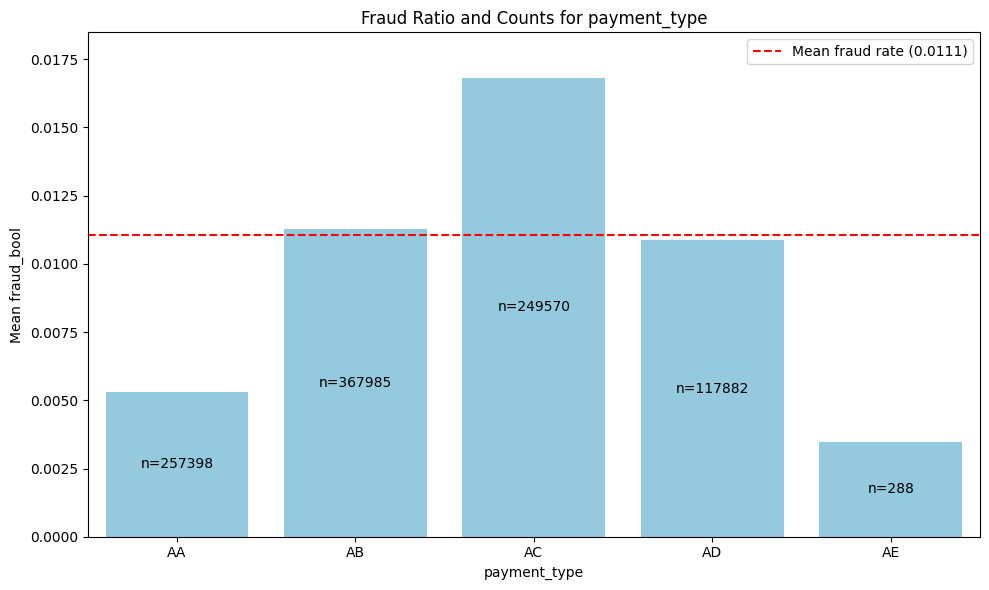

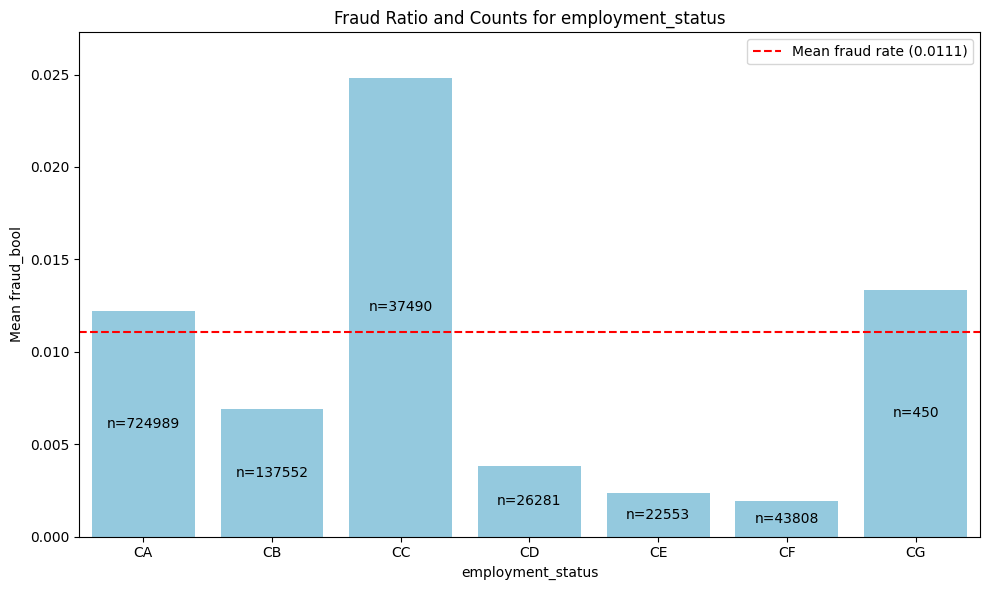

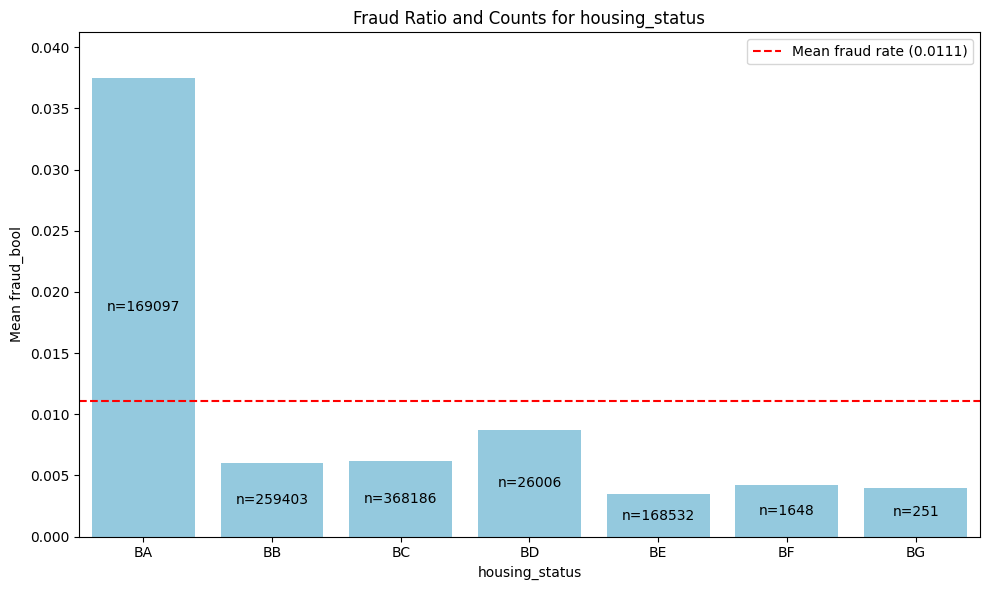

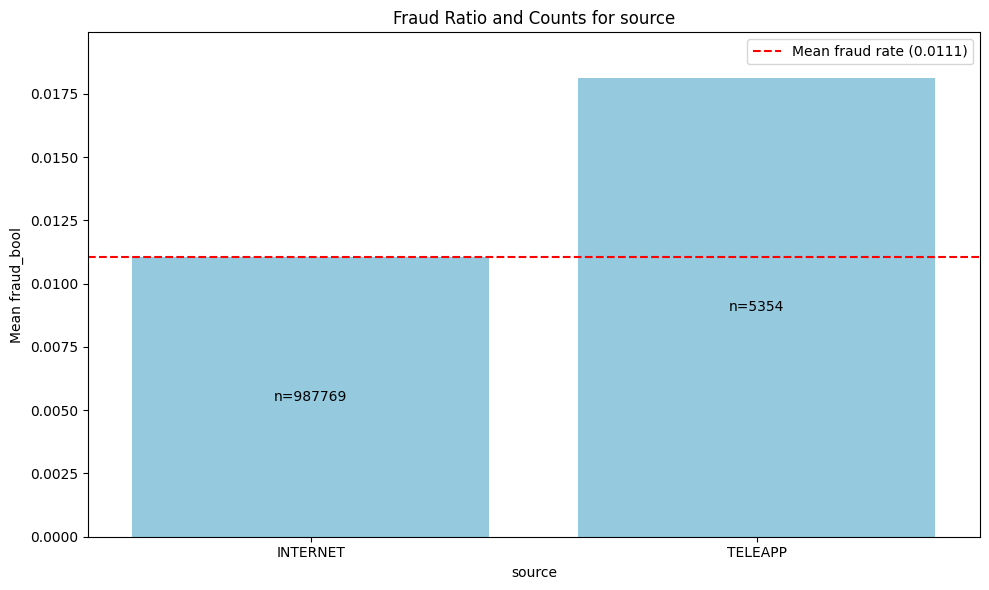

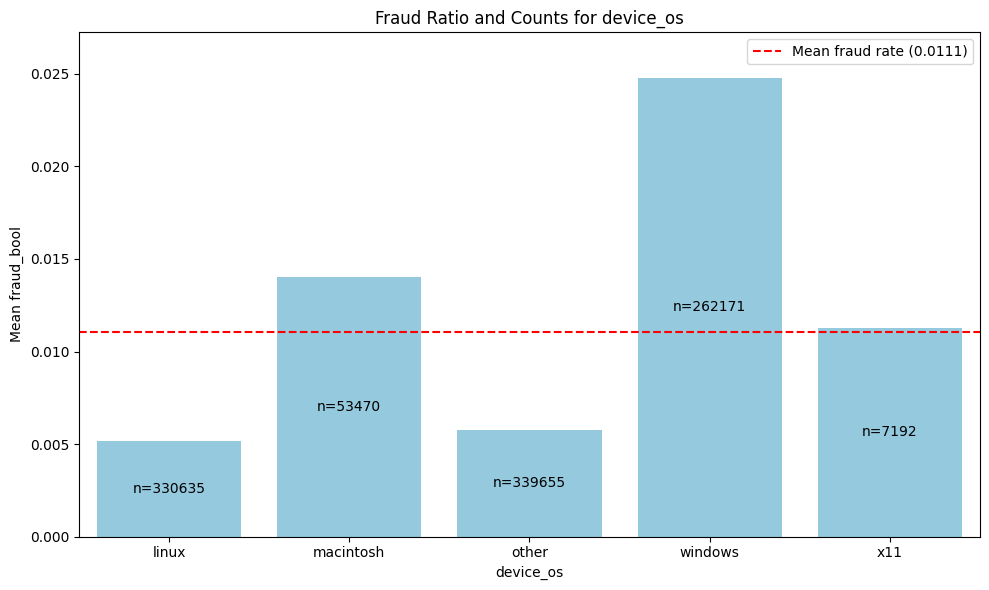

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_fraud_rate = df['fraud_bool'].mean()

# For all categorical features, plot the mean fraud rate per unique value,
# annotate with the count per value using a barplot with text annotation
for col in df.select_dtypes(include='object').columns:
    plt.figure(figsize=(10, 6))
    
    # Calculate mean fraud rate and count for each category
    fraud_rate = df.groupby(col)['fraud_bool'].mean()
    counts = df[col].value_counts().sort_index()
    
    # Barplot of fraud rate per category
    ax = sns.barplot(x=fraud_rate.index, y=fraud_rate.values, color='skyblue')
    
    # Draw mean fraud rate as a horizontal line
    plt.axhline(mean_fraud_rate, color='red', linestyle='--', label=f'Mean fraud rate ({mean_fraud_rate:.4f})')

    # Annotate with counts inside the bars (vertically centered, color depends on bar height for visibility)
    for i, (label, count) in enumerate(counts.items()):
        bar_height = fraud_rate[label]
        y = bar_height / 2  # place text at half the bar height
        color = "black" if bar_height < 0.5 else "white"
        plt.text(
            i, y, f"n={count}",
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=10,
            color=color
        )
    
    plt.title(f'Fraud Ratio and Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Mean fraud_bool')
    plt.ylim(0, 1.1 * max(fraud_rate.max(), mean_fraud_rate))
    plt.legend()
    plt.tight_layout()
    plt.show()


## Turn the categorical columns into one hot encoded features

In [15]:
# For all categorical features, use one-hot encoding
categorical_types = df.select_dtypes(include=['object']).columns

print(f"Number of columns before one-hot encoding: {len(df.columns)}")
# Perform one-hot encoding on those columns
df = pd.get_dummies(df, columns=categorical_types, drop_first=True)

print(f"Number of columns after one-hot encoding: {len(df.columns)}")

Number of columns before one-hot encoding: 31
Number of columns after one-hot encoding: 47


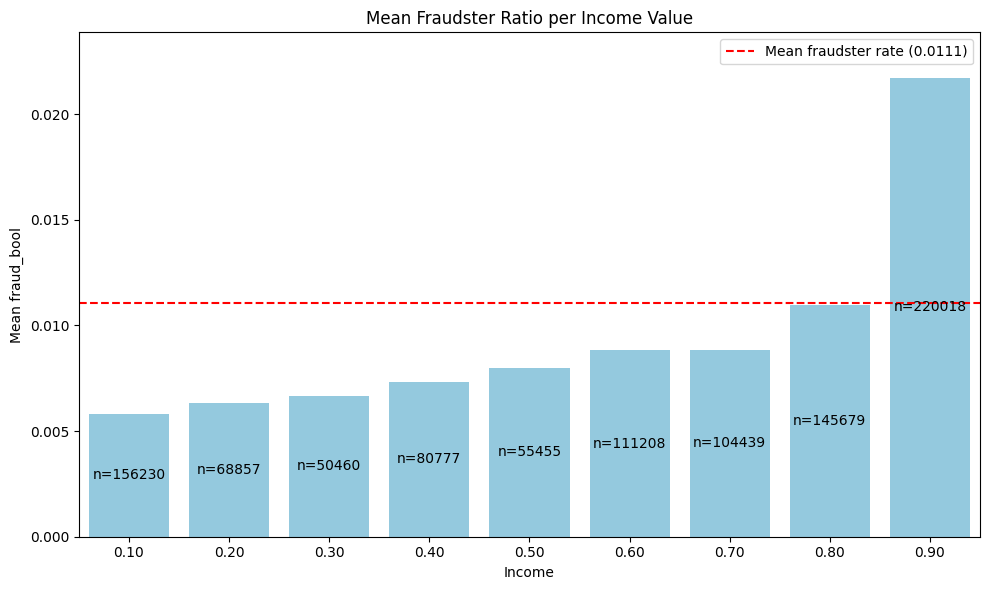

In [16]:
# Group by income and get fraud rate and count per income value
income_fraud_rate = df.groupby('income')['fraud_bool'].mean()
income_counts = df['income'].value_counts().sort_index()
mean_fraud_rate = df['fraud_bool'].mean()

plt.figure(figsize=(10, 6))
bar = sns.barplot(x=[f"{x:.2f}" for x in income_fraud_rate.index], y=income_fraud_rate.values, color='skyblue')

# Display count inside the bar (vertically centered, in white or black depending on fraud rate for contrast)
for i, (income, count) in enumerate(income_counts.items()):
    y = income_fraud_rate[income] / 2  # half way up the bar
    # Choose white or black font depending on bar height for visibility
    color = "black" if income_fraud_rate[income] < 0.5 else "white"
    plt.text(i, y, f"n={count}", ha='center', va='center', fontsize=10, color=color)

plt.axhline(mean_fraud_rate, color='red', linestyle='--', label=f'Mean fraudster rate ({mean_fraud_rate:.4f})')
plt.title('Mean Fraudster Ratio per Income Value')
plt.xlabel('Income')
plt.ylabel('Mean fraud_bool')
plt.ylim(0, 1.1 * max(income_fraud_rate.max(), mean_fraud_rate))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
from src import split_data, preprocess_data, normalize
df_preprocessed = preprocess_data(df)

df_preprocessed.head()


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_preprocessed)
pd.set_option('display.max_columns', None)
X_train.head(20)

# X_train_norm, X_val_norm, X_test_norm, scaler = normalize(X_train, X_val, X_test)

In [ ]:
X_train_norm, X_val_norm, X_test_norm, scaler = normalize(X_train, X_val, X_test)
pd.set_option('display.max_columns', None)
X_train_norm.head(20)

In [ ]:
# training 
from sklearn.metrics import classification_report
import xgboost as xgb

# Set the scale_pos_weight parameter to address class imbalance
# This acts as a global weight for the positive class (label=1).
# Optionally, you can also use sample_weight in fit(), see comments below.

scale_pos_weight = 99  # (weight for 1) / (weight for 0) = 99 / 1 = 99

# Initialize XGBoost model with scale_pos_weight
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Alternatively, for finer control, you could use the sample_weight parameter in fit():
# import numpy as np
# sample_weight = np.where(y_train == 1, 99, 1)
# model.fit(X_train, y_train, sample_weight=sample_weight)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

# classification report
print(classification_report(y_val, y_pred))